# Calcolo correlazione feature-score & feature-feature

Supponiamo che le features abbiano una relazione lineare con lo score di basicness. Ci interessa quindi principalmente la correlazione di **Pearson** tra le features e lo score di **basicness**.

# Utilities

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from tabulate import tabulate
import seaborn as sns

In [2]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [3]:
df_basicness_score_file = '../df_basicness_score.csv'
dataframe = pd.read_csv(df_basicness_score_file)
print(len(dataframe))

82115


In [4]:
# sono state escluse le features del gold standard
features_list = ['In CBT'] + [col for col in dataframe.columns if col.startswith('Normalized') and col != 'Normalized timeDiffs mean']
print(features_list)

['In CBT', 'Normalized Depth', 'Normalized LCH Similarity', 'Normalized Frequency', 'Normalized Synonymy']


In [5]:
# La colonna In CBT contiene valori T/F, convertiamo in 0/1
dataframe['In CBT'] = dataframe['In CBT'].astype(int)

# Metodi

In [6]:
methods_list = ['pearson','spearman', 'kendall']

## Pearson

- Un valore assoluto maggiore di r indica una correlazione più forte, più vicina a una funzione lineare. 
- Un valore assoluto più piccolo di r indica una correlazione più debole.

## Spearman

È calcolato allo stesso modo del coefficiente di correlazione di Pearson, ma tiene conto dei loro ranghi invece dei loro valori. 

- Può prendere un valore reale nell'intervallo −1 ≤ ρ ≤ 1.

- Il suo valore massimo ρ = 1 corrisponde al caso in cui c'è una funzione monotonicamente crescente tra x e y. In altre parole, i valori x più grandi corrispondono a valori y più grandi e viceversa.

- Il suo valore minimo ρ = −1 corrisponde al caso in cui c'è una funzione monotonicamente decrescente tra x e y. In altre parole, i valori x più grandi corrispondono a valori y più piccoli e viceversa.

## Kendall

Il coefficiente di correlazione di Kendall confronta il numero di coppie di dati concordanti e discordanti. Questo coefficiente si basa sulla differenza nei conteggi delle coppie concordanti e discordanti rispetto al numero di coppie x-y.

- Può prendere un valore reale nell'intervallo −1 ≤ τ ≤ 1.

- Il suo valore massimo τ = 1 corrisponde al caso in cui i rank dei valori corrispondenti in x e y sono gli stessi. In altre parole, tutte le coppie sono concordanti.

- Il suo valore minimo τ = −1 corrisponde al caso in cui i rank in x sono l'inverso dei rank in y. In altre parole, tutte le coppie sono discordanti.

# Funzione calcolo correlazione tra coppie

In [7]:
def get_correlation(selected_method, x, y):
    correlation = x.corr(y, method=selected_method)
    return correlation

# Correlazione tra coppie di features

In [8]:
def get_all_feature_correlations(dataframe, methods_list):
    correlations = {}
    columns = dataframe.columns

    for i, feature1 in enumerate(columns):
        for j, feature2 in enumerate(columns):
            if i < j:  # Evitare di calcolare la stessa correlazione due volte
                for method in methods_list:
                    correlation_key = f'{feature1} vs {feature2} ({method})'
                    x = dataframe[feature1]
                    y = dataframe[feature2]
                    correlation = get_correlation(method, x, y)
                    correlations[correlation_key] = correlation

    df_correlations = pd.DataFrame(list(correlations.items()), columns=['Feature Pair Method', 'Correlation'])
    return correlations, df_correlations

def print_all_feature_correlations(dataframe, methods_list):
    correlations, _ = get_all_feature_correlations(dataframe, methods_list)
    
    rows = []
    for correlation_key, correlation_value in correlations.items():
        feature_pair, method = correlation_key.split(' (')
        rows.append([feature_pair, method[:-1], correlation_value])
    
    headers = ['Feature Pair', 'Method', 'Correlation']
    print(tabulate(rows, headers=headers, floatfmt=".3f", tablefmt="fancy_grid"))


# Correlazione tra ogni singola feature e score

In [9]:
def get_correlation_single_feature_score(dataframe, features_list, methods_list, score_column_name):
    y = dataframe[score_column_name]
    
    feature_correlation_dict = {}
    for feature in features_list:
        for method in methods_list:
            feature_correlation = feature + '_' + method
            x = dataframe[feature]
            correlation = get_correlation(method, x, y)
            feature_correlation_dict[feature_correlation] = correlation

    df_feature_correlation = pd.DataFrame(list(feature_correlation_dict.items()), columns=['Feature Method', 'Correlation'])
    
    return feature_correlation_dict, df_feature_correlation

# Serve solo per stampare tabella risultati
def extract_categories(data_dict):
    categories = {}
    for key in data_dict.keys():
        feature, method = key.split('_')
        categories.setdefault(feature, []).append(method)
    return categories

# Serve solo per stampare tabella risultati
# Crea DataFrame per ciascuna feature e rinomina le colonne
def create_and_rename_df(category_prefix, data_dict):
    df = pd.DataFrame({k: data_dict[k] for k in data_dict.keys() if category_prefix.lower() in k.lower()}, index=['Value'])
    df.columns = [col.split('_')[-1].capitalize() for col in df.columns]
    return df

# Serve solo per stampare tabella risultati
def print_feature_score_correlations(dataframe, features_list, methods_list, score_column_name):
    feature_correlation_dict, _ = get_correlation_single_feature_score(dataframe, features_list, methods_list, score_column_name)
    categories = extract_categories(feature_correlation_dict)
    for feature, _ in categories.items():
        df = create_and_rename_df(feature, feature_correlation_dict)
        print(f"\nCorrelation {feature} - {score_column_name}:")
        print(df)


# Visualizzazione (Pearson correlation coefficient)

In [10]:
plt.style.use('ggplot')

## Plot della matrice di correlazione (Pearson) tra ogni singola feature e basicness score

In [11]:
def plot_correlation_single_feature_score(dataframe, df_score, score_name):
    for feature in features_list:
        df_selected_feature = dataframe[feature]
        slope, intercept, r, p, stderr = scipy.stats.linregress(df_selected_feature, df_score)
        line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
        fig, ax = plt.subplots()
        ax.plot(df_selected_feature, df_score, linewidth=0, marker='s', label='Data points')
        ax.plot(df_selected_feature, intercept + slope * df_selected_feature, label=line)
        ax.set_xlabel(feature)
        ax.set_ylabel(score_name)
        ax.legend(facecolor='white')
        plt.title('Pearson correlation matrix')
        
        if score_name == "Basicness score":
            path_filename_output = "../features/correlation_scatterplot/" + feature + "-" + score_name + "_correlation_scatterplot.png"
            plt.savefig(path_filename_output, dpi=300)
        
        plt.show()

# HeatMap delle matrici di correlazione

In [12]:
def plot_correlation_heatmap(dataframe, score_type=None):
    for selected_method in methods_list:
        corr_matrix = dataframe.corr(method=selected_method).round(2)
        vmin, vmax = corr_matrix.min().min(), corr_matrix.max().max()

        plt.figure(figsize=(10, 8))
        ax = sns.heatmap(corr_matrix, annot=True, cmap='OrRd', vmin=vmin, vmax=vmax, linewidths=0.5)
        plt.title(f'{selected_method} correlation heatmap')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        if score_type == 'Basicness score':
            path_filename_output = "../features/correlation_heatmaps/" + selected_method + "_correlation_heatmap.png"
            plt.savefig(path_filename_output, dpi=300)
        
        plt.show()

## Heatmap della correlazione (Pearson) tra ogni singola feature e score

In [13]:
def plot_heatmap_correlation_single_feature_score(dataframe, features_list, score_column_name):
    for feature in features_list:
        df = dataframe[[feature]+[score_column_name]]
        plot_correlation_heatmap(df, score_column_name)

## Heatmap della correlazione (Pearson) tra tutte le feature e score

In [14]:
def plot_heatmap_correlation_all_features_score(dataframe, features_list, score_column_name):
    df = dataframe[features_list+[score_column_name]]
    plot_correlation_heatmap(df, score_column_name)

## Heatmap della correlazione (Pearson) tra tutte le feature

In [15]:
def plot_heatmap_correlation_all_features(dataframe, features_list):
    df = dataframe[features_list]
    plot_correlation_heatmap(df)

# RISULTATI

## Correlazione feature - basicness score

In [16]:
analize_basicness_score = True
score_column_name = 'Basicness score' if analize_basicness_score else 'Agreement score'
y = dataframe[score_column_name]

### Correlazione 
tra ogni singola feature e basicness score

In [17]:
print_feature_score_correlations(dataframe, features_list, methods_list, score_column_name)


Correlation In CBT - Basicness score:
       Pearson  Spearman   Kendall
Value  0.68223  0.602349  0.493223

Correlation Normalized Depth - Basicness score:
        Pearson  Spearman   Kendall
Value  0.241834  0.363473  0.294615

Correlation Normalized LCH Similarity - Basicness score:
        Pearson  Spearman   Kendall
Value  0.248641  0.363473  0.294615

Correlation Normalized Frequency - Basicness score:
        Pearson  Spearman   Kendall
Value  0.884365  0.845948  0.677385

Correlation Normalized Synonymy - Basicness score:
       Pearson  Spearman   Kendall
Value  0.00723  0.061702  0.047917


### Plot 
della matrice di correlazione (Pearson) tra ogni singola feature e basicness score

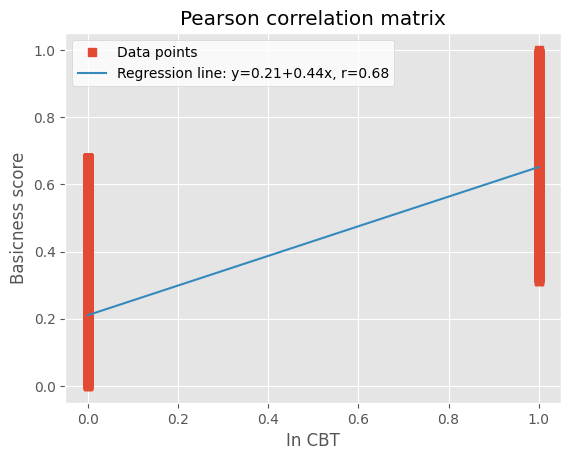

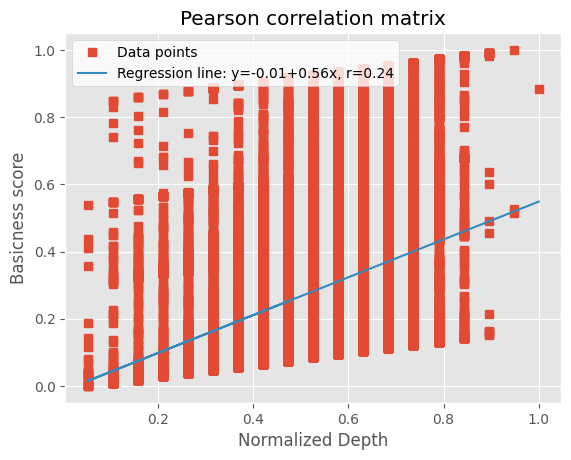

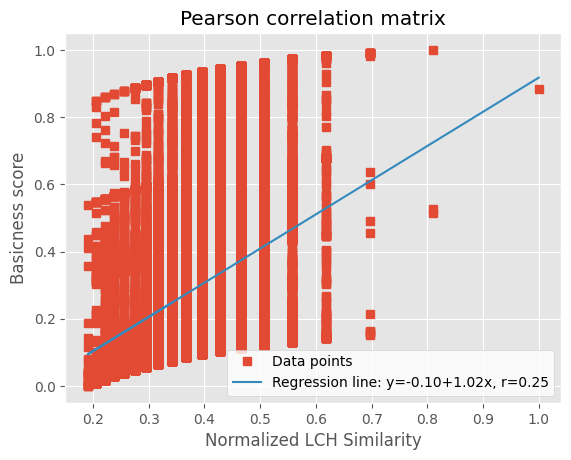

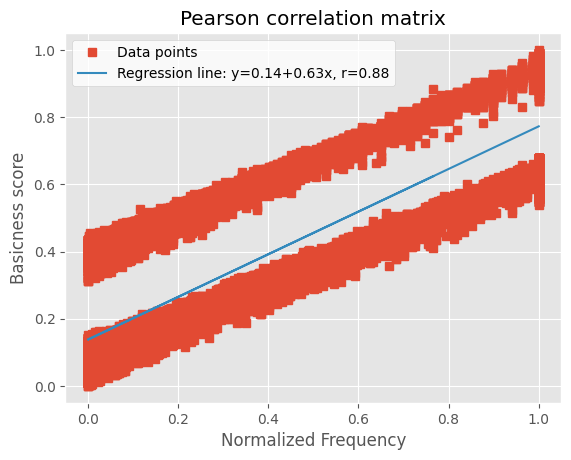

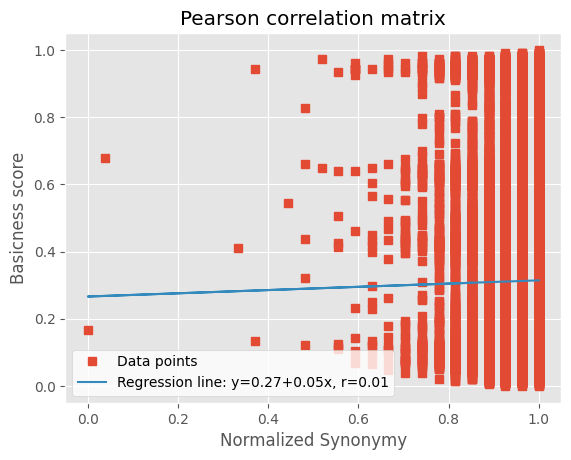

In [18]:
plot_correlation_single_feature_score(dataframe, y, score_column_name)

### Heatmap 
della correlazione (Pearson) tra tutte le feature e basicness score

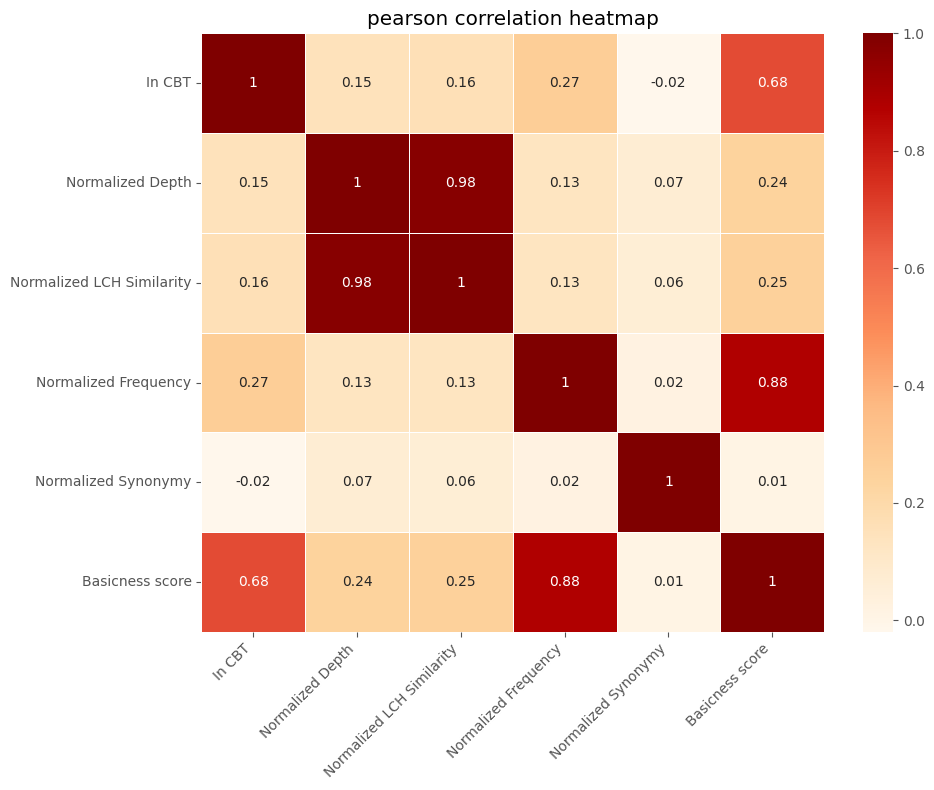

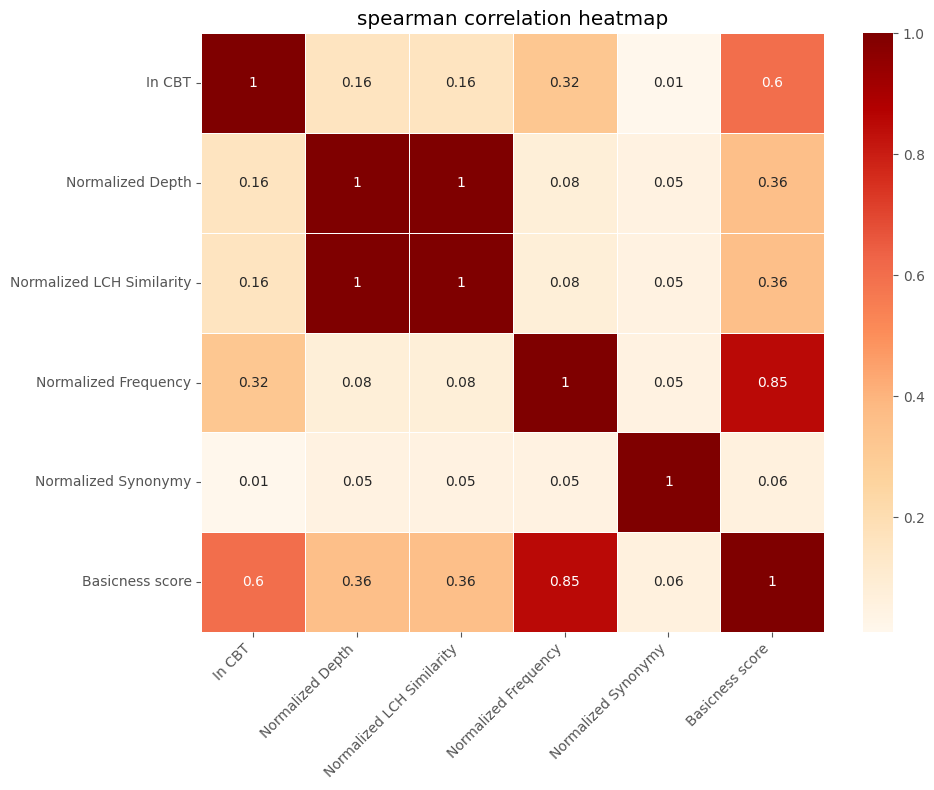

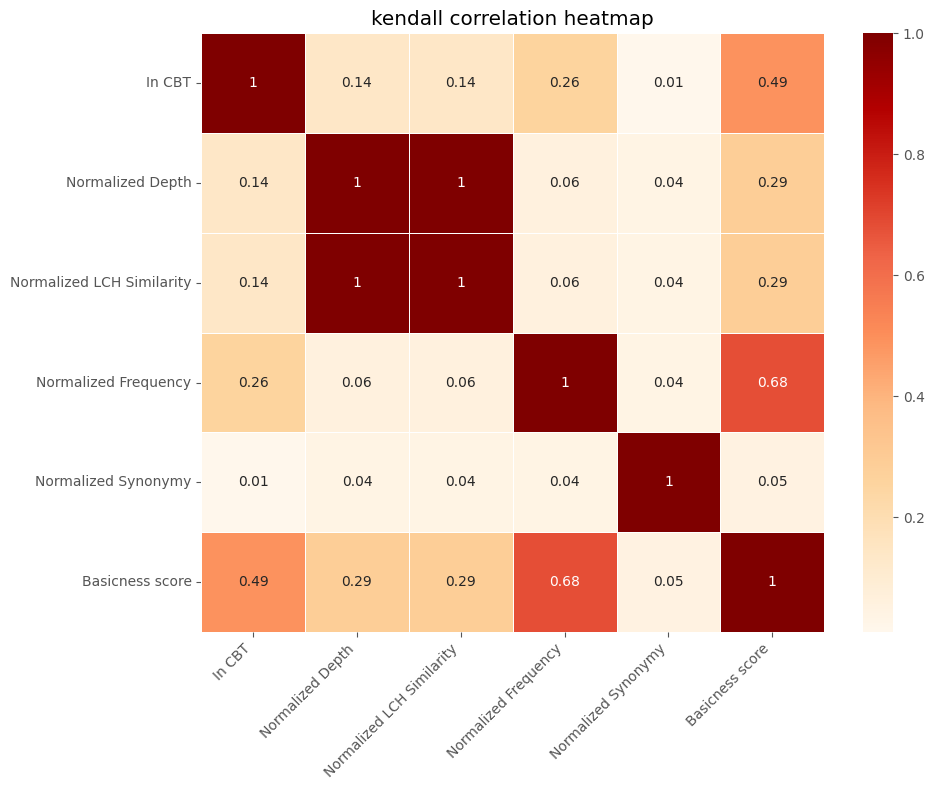

In [19]:
plot_heatmap_correlation_all_features_score(dataframe, features_list, score_column_name)

## Correlazione feature - agreement score

Dobbiamo lavorare solo con i synset che hanno agreement.

In [20]:
analize_basicness_score = False
score_column_name = 'Basicness score' if analize_basicness_score else 'Agreement score'

In [21]:
df_clean = dataframe.copy()
df_clean = df_clean.dropna(subset=['Agreement score'])

y_clean = df_clean[score_column_name]
x_clean = df_clean[features_list]

Possiamo anche aggiungere come feature 'timeDiffs' e 'isHard'

In [22]:
new_features_list = ['isHard mean', 'timeDiffs mean', 'In CBT'] + [col for col in df_clean.columns if col.startswith('Normalized')]
x_clean_new = df_clean[new_features_list]

x_clean_new.loc[:, ['isHard mean', 'timeDiffs mean']] = scaler.fit_transform(x_clean_new[['isHard mean', 'timeDiffs mean']])

### Correlazione 
tra ogni singola feature e agreement score

In [23]:
print_feature_score_correlations(df_clean, features_list, methods_list, score_column_name)


Correlation In CBT - Agreement score:
        Pearson  Spearman   Kendall
Value  0.669754  0.653756  0.577392

Correlation Normalized Depth - Agreement score:
        Pearson  Spearman   Kendall
Value  0.349241  0.355247  0.278153

Correlation Normalized LCH Similarity - Agreement score:
        Pearson  Spearman   Kendall
Value  0.354178  0.355247  0.278153

Correlation Normalized Frequency - Agreement score:
        Pearson  Spearman   Kendall
Value  0.786248   0.78824  0.658763

Correlation Normalized Synonymy - Agreement score:
        Pearson  Spearman   Kendall
Value -0.210596 -0.274721 -0.219416


### Plot 
della matrice di correlazione (Pearson) tra ogni singola feature e agreement score

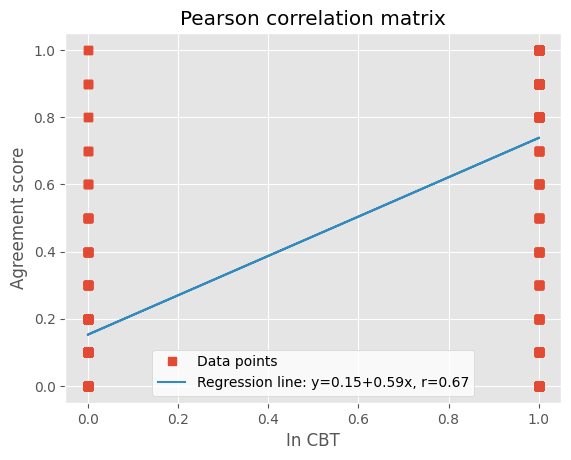

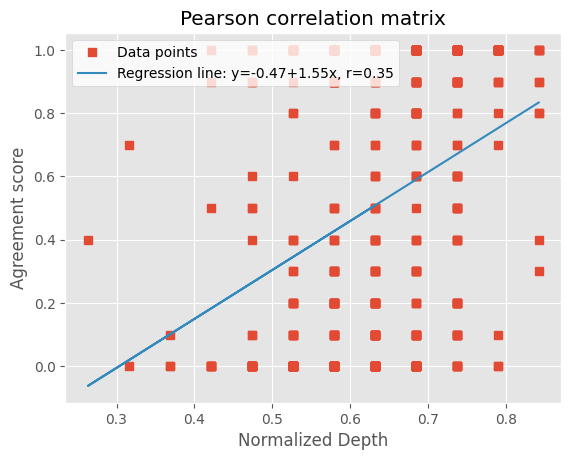

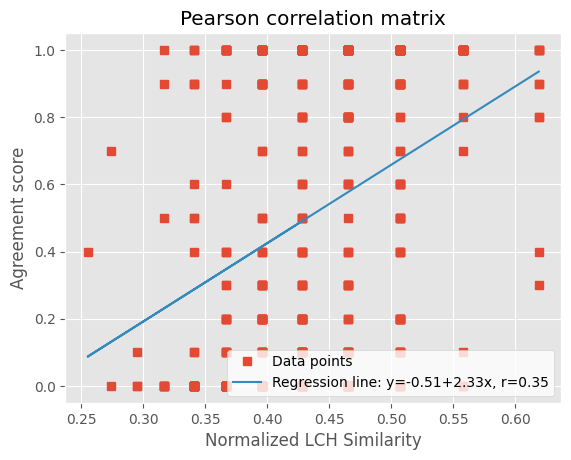

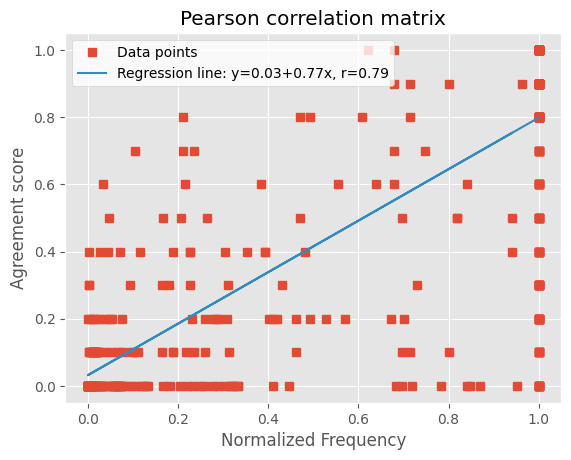

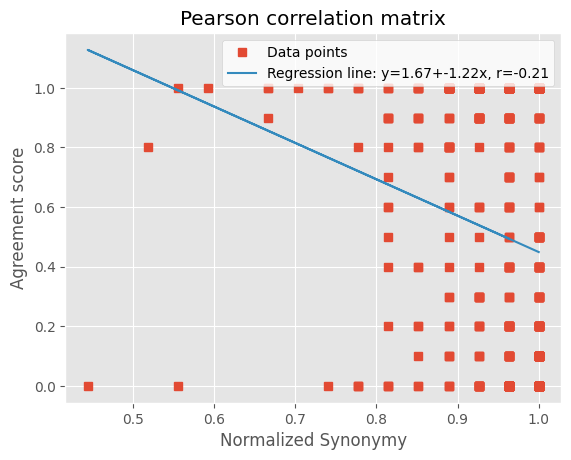

In [24]:
plot_correlation_single_feature_score(df_clean, y_clean, score_column_name)

### Heatmap 
della correlazione (Pearson) tra tutte le feature e agreement score

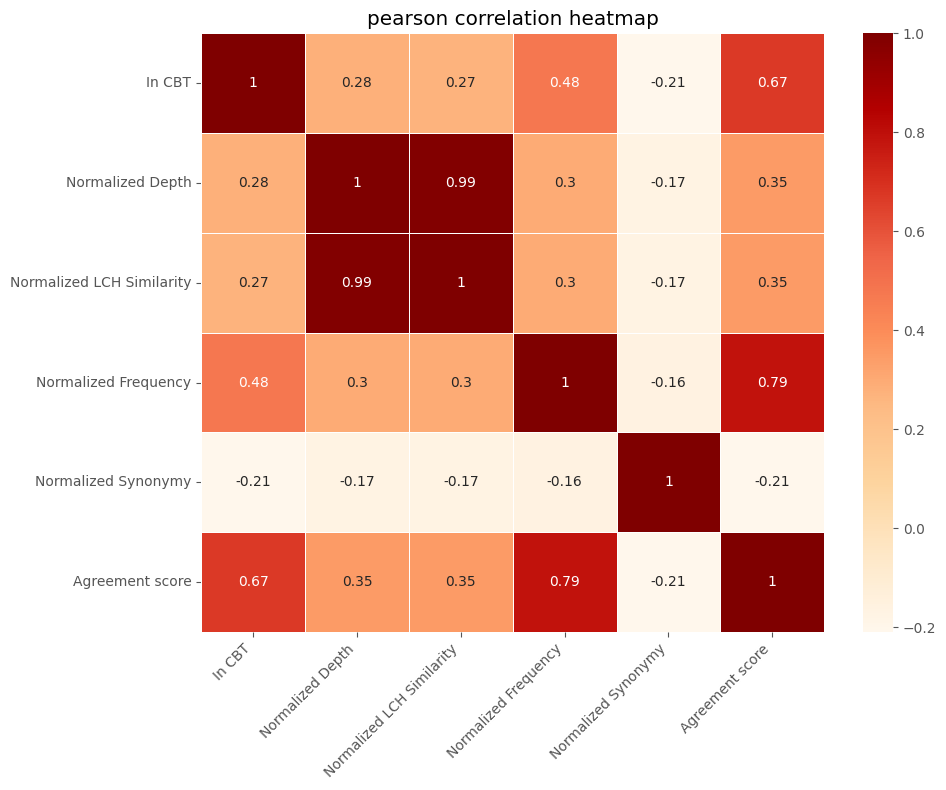

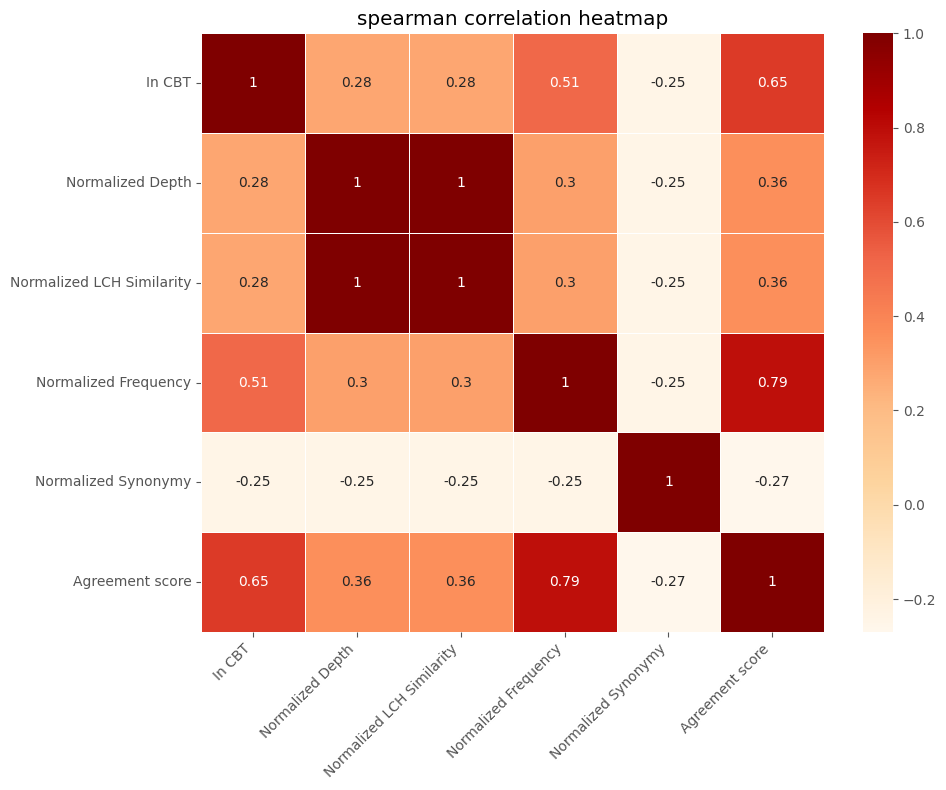

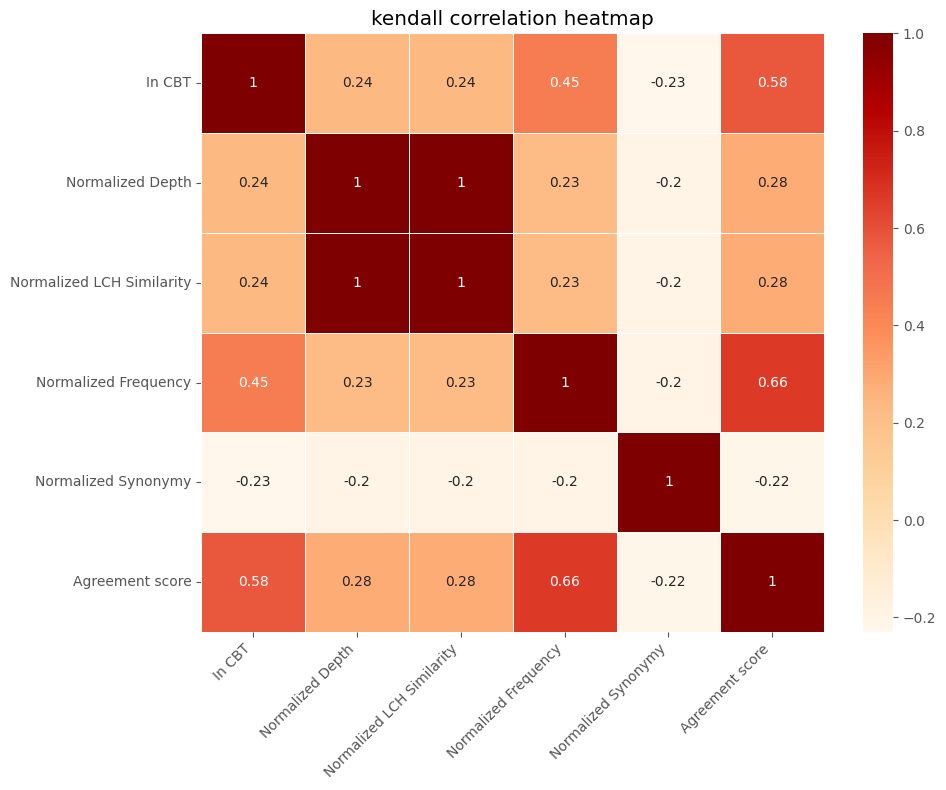

In [25]:
plot_heatmap_correlation_all_features_score(df_clean, features_list, score_column_name)

## Correlazione tra tutte le features

### Correlazione tra coppie di features

In [26]:
df_only_features = dataframe[features_list]
# print_all_feature_correlations(df_only_features, methods_list)

### Heatmap 
della correlazione (Pearson) tra tutte le feature

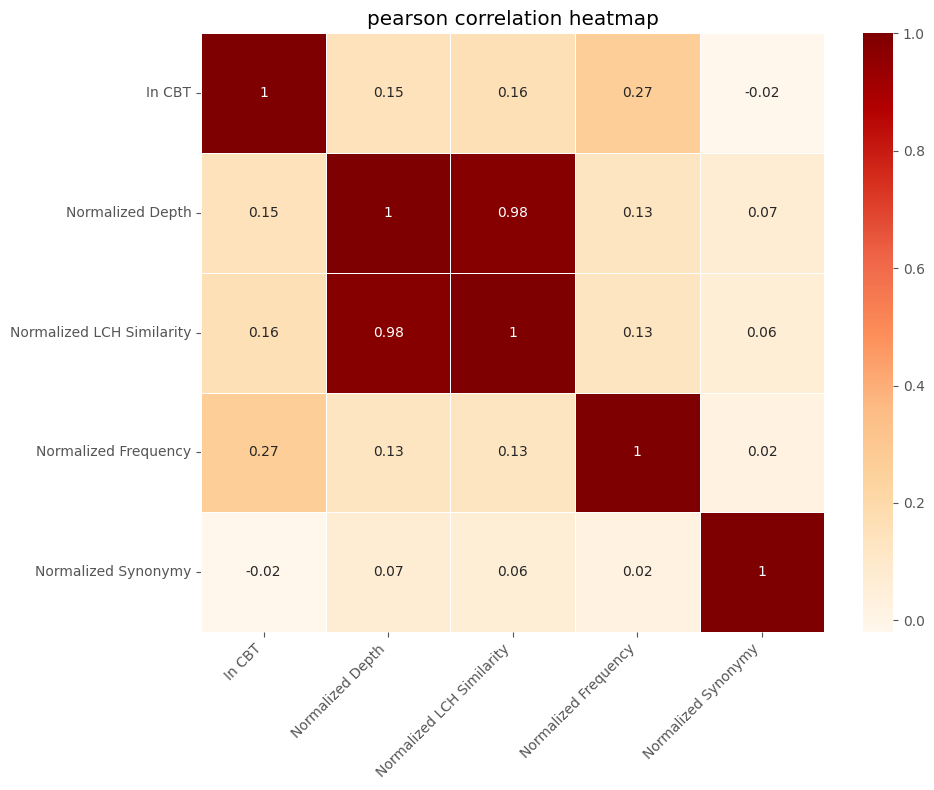

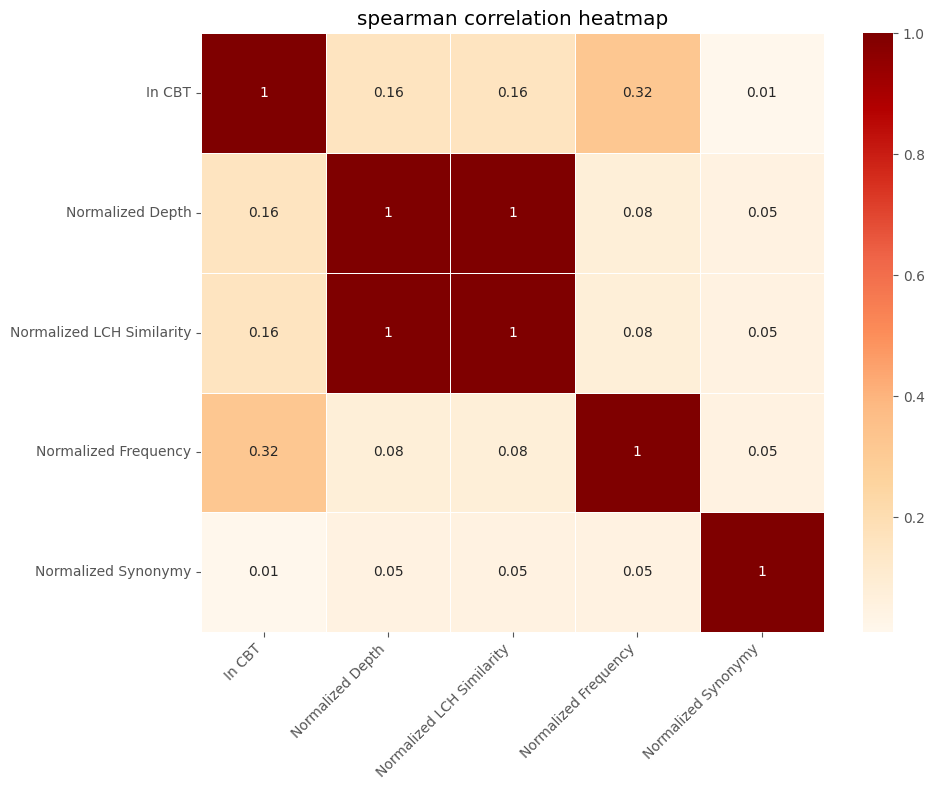

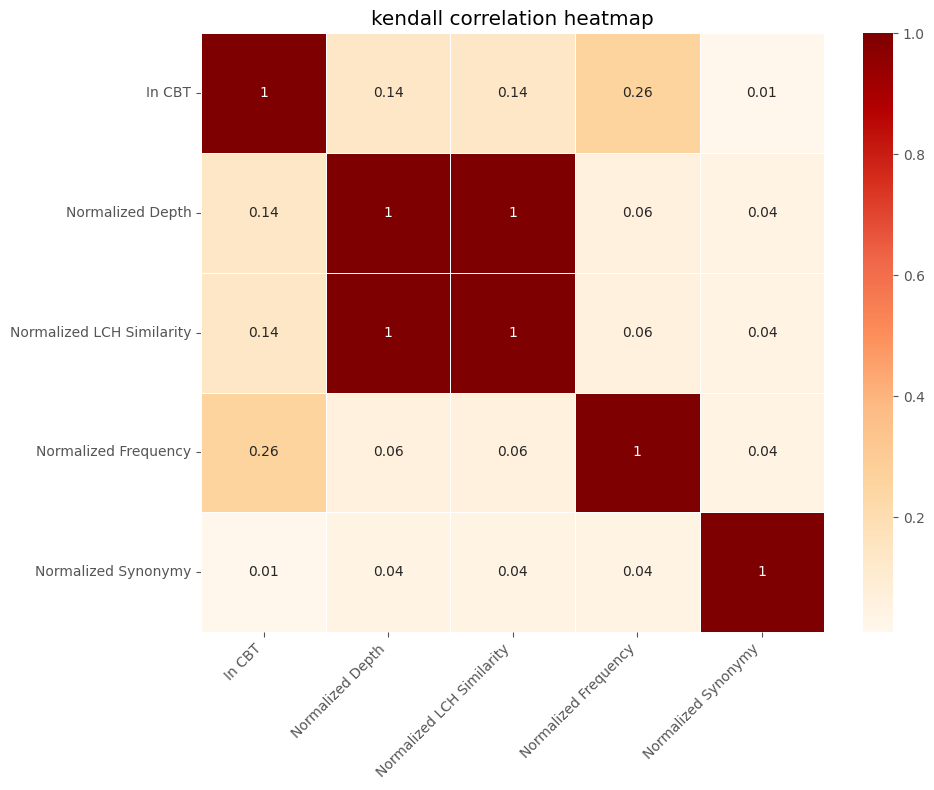

In [27]:
plot_heatmap_correlation_all_features(dataframe, features_list)